# Basic tour through turbESN



-Florian Heyder 31.03.2022

## Imports

In [1]:
import torch
import numpy as np
import h5py
import matplotlib.pyplot as plt

import turbESN
from turbESN.core import ESN
from turbESN.util import *

### Import Data

Text(0.5, 0, 'time step')

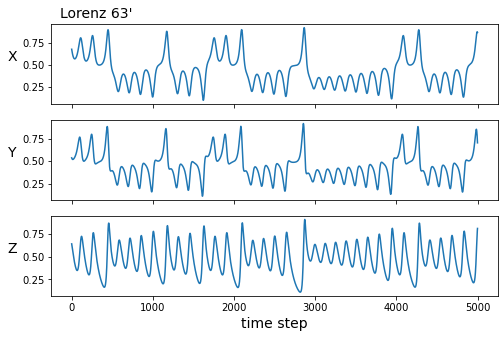

In [2]:
data = np.load('Lorenz63.npy')
data_timesteps, n_input_data= data.shape

# Visualize data
ylabels = ['X','Y','Z']
fig,axs = plt.subplots(figsize = (8,5), nrows = 3, sharex = True)
for ii in range(n_input_data):
    axs[ii].plot(data[:,ii])  
    axs[ii].set_ylabel(ylabels[ii], fontsize = 14, rotation = 0, labelpad = 10)
axs[0].set_title("Lorenz 63'", x = .1, fontsize = 14)
axs[-1].set_xlabel('time step',fontsize = 14)

### Prepare Data for ESN

In [18]:
# Scale data
from sklearn.preprocessing import minmax_scale
data_scaled = minmax_scale(data,axis = 0)   #scale each mode to [0,1]
data_scaled -=0.5
data_scaled *=2

# Data parameters
trainingLength = 2049
testingLength = 1000
validationLength = 1000
transientTime = 49
esn_start = 1
esn_end = esn_start + trainingLength + testingLength + validationLength

u_train, y_train, u_test, y_test, u_val, y_val = PreparePredictorData(data = data_scaled, 
                                                         n_input = n_input_data, 
                                                         trainingLength = trainingLength, 
                                                         testingLength = testingLength, 
                                                         validationLength = validationLength,
                                                         esn_start = esn_start,
                                                          esn_end = esn_end)

### Initialize ESN 

In [19]:
# Hyperparameters
randomSeed = 41
n_reservoir = 256
leakingRate = 0.1
spectralRadius =  1.1
reservoirDensity = 0.2
regressionParameter = 5e-1

#ESN
esn = ESN(randomSeed = randomSeed,
           esn_start = esn_start,
           esn_end = esn_end,
           trainingLength = trainingLength,
           testingLength = testingLength,
           validationLength = validationLength,
           data_timesteps = data_timesteps,
           n_input = n_input_data,
           n_output = n_input_data,
           n_reservoir = n_reservoir,
           leakingRate = leakingRate,
           spectralRadius = spectralRadius,
           reservoirDensity = reservoirDensity,
           regressionParameter = regressionParameter,
           bias_in = 1,
           bias_out = 1,
           outputInputScaling = 1.0,
           inputScaling = 1.0,
           inputDensity = 1.0,
           noiseLevel_in = 0.0,
           noiseLevel_out = 0.0,
           mode = 'auto',
           weightGeneration = 'uniform',
           transientTime  = transientTime,
           use_watts_strogatz_reservoir = False,
           ws_p = 0.3,
           verbose = False)

### Run ESN 

In [20]:
mse_train, mse_test, mse_val, y_pred_test, y_pred_val = RunturbESN(esn=esn, 
                                                          u_train=u_train, 
                                                          y_train=y_train, 
                                                          y_test=y_test, 
                                                          u_test=u_test, 
                                                          u_val=u_val,
                                                          y_val=y_val)

### Evaluate Result

Text(0.5, 0, 'time step')

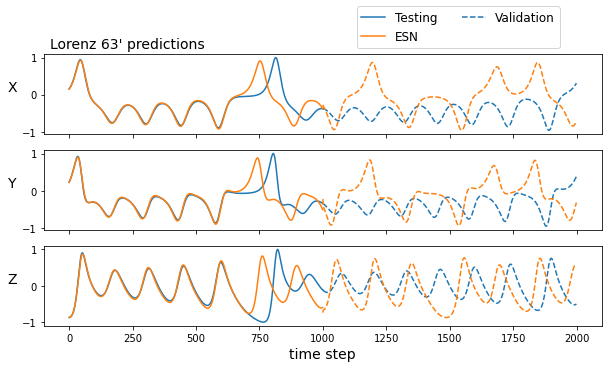

In [21]:
import seaborn as sns
ylabels = ['X','Y','Z']
clrs = sns.color_palette()
fig,axs = plt.subplots(figsize = (10,5), nrows = 3, sharex = True)
for ii in range(n_input_data):
    axs[ii].plot(range(testingLength),y_test[:,ii], label = 'Testing',color = clrs[0])
    axs[ii].plot(range(testingLength),y_pred_test[:,ii], label = 'ESN',color=clrs[1])
    axs[ii].plot(range(testingLength,testingLength+validationLength),y_val[:,ii], label = 'Validation',linestyle = "dashed",color = clrs[0])
    axs[ii].plot(range(testingLength,testingLength+validationLength),y_pred_val[:,ii], label = '',linestyle = "dashed",color=clrs[1])
    axs[ii].set_ylabel(ylabels[ii], fontsize = 14, rotation = 0, labelpad = 10)
    #axs[ii].grid()
    
axs[0].legend(fontsize = 12, ncol = 2, loc = 'lower left', bbox_to_anchor = (.55,1))
axs[0].set_title("Lorenz 63' predictions", x = .15, fontsize = 14)
axs[-1].set_xlabel('time step',fontsize = 14)

Text(0, 0.5, 'Z')

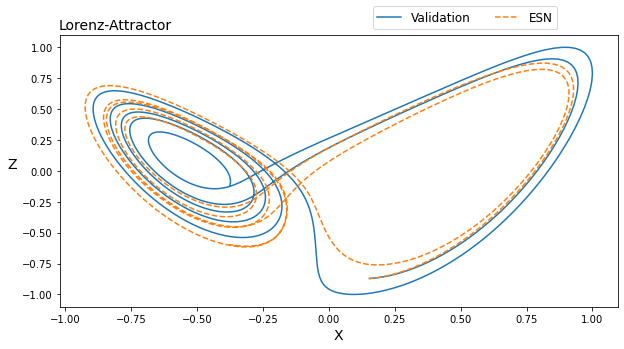

In [22]:
fig,axs = plt.subplots(figsize = (10,5))
axs.plot(y_test[:,0],y_test[:,2],label = 'Validation')
axs.plot(y_pred_test[:,0],y_pred_test[:,2],label = 'ESN', linestyle = 'dashed')
axs.legend(fontsize = 12, ncol = 2, loc = 'lower left', bbox_to_anchor = (.55,1))
axs.set_title("Lorenz-Attractor", x = .1, fontsize = 14)
axs.set_xlabel("X", fontsize = 14, rotation = 0)
axs.set_ylabel("Z", fontsize = 14, rotation = 0, labelpad = 10)
